In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import pandas as pd
import numpy as np
from tifffile import imread
from nd2reader import ND2Reader

import napari
from napari import Viewer
from magicgui.widgets import Container
from magicgui import magicgui

sys.path.append('../libraries')
import general_functions as gen
import napari_build_viewer as bv_f
import input_functions as inp_f

In [2]:
warnings.filterwarnings('ignore')

## Define experiment

In [3]:
info_file_path = r'D:\BARC\BARC_Wanjuan\210603_B3_5\210603_halo_B3_5_info.txt'

In [4]:
# read the file
info_file = open(info_file_path, 'r')
info_lines = info_file.readlines()
info_file.close()

# read info about the data frame
exp_dir,df_name = inp_f.read_df_info(info_lines)

# read in the data frame
df = pd.read_pickle(os.path.join(exp_dir,'df',df_name))

# get info about the channels
channel_list = inp_f.read_channels(info_lines,check=True,df=df,exp_dir=exp_dir)

# get info about the tags
tag_list = inp_f.read_tags(info_lines,df=df)

# get info about what will be plotted
graph_list = inp_f.read_graphs(info_lines,df,channel_list)

# get info about the general settings
time_threshold,small_im_size,label_contour,gen_track_columns = inp_f.read_settings(info_lines)

# get info about the caluclations 
object_properties = inp_f.read_properties(info_lines)
# consider pushing properties_ring too

## Extract info from the data frame

In [5]:
# sort 
df = df.sort_values(by=['track_id','t'])

Expected execution time < 1min.

In [6]:
%%time

# generate labels layer
labels = gen.labels_from_df(df)

Wall time: 6.31 s


In [7]:
# generate data for the tracking layer
data,properties,graph = gen.trackData_from_df(df,col_list = gen_track_columns)

In [8]:
# create data for tagging
tag_data = gen.tags_from_df(df,tag_list)

## Read in images

Expected execution time ~ 10s/1GB

In [9]:
%%time

for ind,ch in enumerate(channel_list):
    
    im_path = os.path.join(exp_dir,'data',ch['file_name'])
    c = ch['channel_in_file']
    
    channel_list[ind]['image'] = inp_f.open_movie(im_path,c)

Wall time: 812 ms


## Create a viewer

In [24]:
viewer = napari.Viewer()

# add a labels layer
labels_layer = viewer.add_labels(labels,name='Labels',opacity = 0.4)

# add a helper layer
layer_mod = viewer.add_points([],name='Helper Points',face_color='red',ndim=3)

# add a tracking layer
track_layer=viewer.add_tracks(data, properties=properties,graph=graph,name='Tracking') #graph=graph

track_layer.display_id=True

# add tracks annotations
for tag,tag_points in zip(tag_list,tag_data): 
    
    viewer.add_points(tag_points,name=tag['tag_name'],face_color=tag['tag_color'],opacity = 1,ndim = 3)

# add image layers
for ind,ch in reversed(list(enumerate(channel_list))):
    
    viewer.add_image(ch['image'],name=ch['channel_name'],colormap=ch['color'],blending='additive')


In [25]:
# create a plot widget
t_max = viewer.dims.range[0][1]
plot_widget = bv_f.build_lineage_widget(t_max)

## Build viewer functionality

In [27]:
# inject global variables to the module

global_variables = ['viewer','plot_widget',
                    'exp_dir','df_name','df',
                    'channel_list','graph_list',
                    'object_properties',
                    'time_threshold',
                    'tag_list','gen_track_columns',
                    'small_im_size',
                    'label_contour'
                   ]

for var in global_variables:
    
    exec(f'bv_f.{var} = {var}')

In [28]:
######################################################################
# add saving button
save_data = magicgui(bv_f.save_data, call_button='Save Data')
viewer.window.add_dock_widget(save_data,area='right')

######################################################################
# add right-click to make a label active
select_label = labels_layer.mouse_drag_callbacks.append(bv_f.select_label)

######################################################################
# add label modifications

mod_label = magicgui(bv_f.mod_label,call_button='Modify Label')
viewer.window.add_dock_widget(mod_label,area='right')

mod_key = viewer.bind_key('Enter',overwrite=True,func=bv_f.mod_label)

######################################################################
# add track modifying buttons

cut_track = magicgui(bv_f.cut_track, call_button='Cut Track')
merge_track = magicgui(bv_f.merge_track, call_button='Merge Track')
connect_track = magicgui(bv_f.connect_track, call_button='Connect Track')

container_tracks = Container(widgets=[cut_track,merge_track,connect_track],labels=False)
viewer.window.add_dock_widget(container_tracks,area='right') 

######################################################################
# add right-click toggle track tags
for tag_name in [x['tag_name'] for x in tag_list]:
    
    viewer.layers[tag_name].mouse_drag_callbacks.append(bv_f.toggle_track)
    
######################################################################
# add small stack display button

stack_button = magicgui(bv_f.show_stack, call_button='Show Stack')
viewer.window.add_dock_widget(stack_button,area='right')

########################################################################
# add lineage graph
viewer.window.add_dock_widget(plot_widget,area='bottom',name='family')

# connect lineage graph update
labels_layer.events.selected_label.connect(bv_f.update_lineage_display)

In [29]:
# add lineage graph
#viewer.window.add_dock_widget(plot_widget,area='bottom',name='family')

# connect lineage graph update
labels_layer.events.selected_label.connect(bv_f.update_lineage_display)

<function napari_build_viewer.update_lineage_display(event)>

In [137]:
%load_ext autoreload
%autoreload 2

import napari_display_functions as my_napari

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
# clear the widget
plot_view = plot_widget.getItem(0,0)
plot_view.clear()

# get for whom the update will be
active_label = viewer.layers['Labels'].selected_label

# find graph for everyone
_,_,graph = gen.trackData_from_df(df,col_list = ['track_id'])

# find the root
my_root = int(list(df.loc[df.track_id==active_label,'root'])[0])
paths=gen.find_all_paths(graph,my_root)

# generate the family tree
t = my_napari.generate_tree_min(paths,df)

# calculate rendering
t_rendering = t.render('family_tree.png')

# add positions to the tree
t = my_napari.add_y_rendering(t,t_rendering)

# create view
plot_view = bv_f.render_tree_view(plot_view,t,viewer)

In [160]:
t = my_napari.add_y_rendering(t,t_rendering)

In [166]:
for n in t.traverse():
    
    if n.is_root():
        pass
    else:
        print(t_rendering['node_areas'][n.n][3])

17.0


In [163]:
t_rendering

{'nodes': [[5.846534653465348, 7.0, 9.846534653465348, 11.0, 0, None],
  [188.84653465346534, 7.0, 192.84653465346534, 11.0, 1, None]],
 'faces': [[192.34653465346534, 1.0, 213.34653465346534, 17.0, 1, '154']],
 'node_areas': {0: [1.0, 1.0, 213.34653465346534, 17.0],
  1: [9.346534653465348, 1.0, 213.34653465346534, 17.0]}}

In [154]:
update_lineage_display()

AttributeError: 'TreeNode' object has no attribute 'y'

In [121]:
plot_widget = pg.GraphicsLayoutWidget()
plot_view = plot_widget.addPlot(title="Lineage tree", labels={"bottom": "Time"})
plot_view.setXRange(0, 100)
viewer.window.add_dock_widget(plot_widget,area='bottom',name='family')

In [125]:
plot_widget

In [126]:
test = viewer.window._dock_widgets['family']
test.clear()

AttributeError: 'QtViewerDockWidget' object has no attribute 'clear'

In [128]:
def render_tree_view(plot_view,t_rendering):

    for n in t.traverse():

        if n.is_root():
            pass
        else:

            node_name = n.name

            # get position in time
            x1 = n.start
            x2 = n.stop
            x_signal = [x1,x2]

            # get rendered position (y axis)
            y_signal = [n.y,n.y]

            label_color = labels_layer.get_color(node_name)
            pen = pg.mkPen(color=pg.mkColor((label_color*255).astype(int)),width=5)

            plot_view.plot(x_signal, y_signal,pen=pen)

            text_item = pg.TextItem(str(node_name),anchor=(1,1))
            text_item.setPos(x2,n.y)
            plot_view.addItem(text_item)

            # check if children are present
            if len(n.children)>0:

                for child in n.children:

                    x_signal = [x2,x2]
                    y_signal = [n.y,child.y]
                    plot_view.plot(x_signal, y_signal,pen=pen)
                
    return plot_view

In [12]:
# create widget

def show_family(event):
    
    global viewer
    
    active_label = viewer.layers['Labels'].selected_label
    
    family_im = my_napari.generate_family_image(df,labels_layer,active_label,graph_list[0])
    
    # remove previous graph
    if 'family' in viewer.window._dock_widgets.keys():
        h = viewer.window._dock_widgets['family']
        viewer.window.remove_dock_widget(h)
    
    mpl_widget = FigureCanvas(Figure(tight_layout=True))

    ax = mpl_widget.figure.subplots(1)

    ax.imshow(family_im,extent=[0,220,0,50])
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis='x', colors='white')

    viewer.window.add_dock_widget(mpl_widget,area='bottom',name='family')

In [146]:
viewer.layers['Labels']

<Labels layer 'Labels' at 0x1ba2ddf0308>

In [100]:
# add lineage graph
plot_widget = bv_f.build_lineage_widget()
viewer.window.add_dock_widget(plot_widget,area='bottom',name='family')

In [99]:
plot_widget.clear()

In [68]:
plot_view.clear()

In [47]:
def node_info(track_ind,df):
    
    node_t = df.loc[df.track_id==track_ind,'t']
    node_start = np.min(node_t)
    node_stop = np.max(node_t)
    
    return node_start,node_stop

def generate_tree_min(paths,df):

    '''
    Function that changes paths into a Newick tree 
    '''
    
    t=Tree()

    n = 1
    node_list = []

    for sub in paths:

        # creating a root
        if (len(sub)==1):

            node_start,node_stop = node_info(sub[0],df)
            node_life = node_stop - node_start

            # add empty trunk
            if node_start > 0:

                t.dist = node_start

            else:

                t.dist = 0  

            temp = t.add_child(name=sub[0],dist=node_life)
            exec(f'n{sub[0]} = temp')
            exec(f'n{sub[0]}.add_feature("start", {node_start})')
            exec(f'n{sub[0]}.add_feature("stop", {node_stop})')
            exec(f'n{sub[0]}.add_feature("n", {n})')

            node_list.append(sub[0])
            n=n+1


        if (len(sub)>1):
            for node in sub[1:]:

                if not(node in node_list):

                    node_start,node_stop = node_info(node,df)
                    node_life = node_stop-node_start

                    exec(f'n{node}=n{sub[0]}.add_child(name={node},dist={node_life})')
                    exec(f'n{node}.add_feature("start", {node_start})')
                    exec(f'n{node}.add_feature("stop", {node_stop})')
                    exec(f'n{node}.add_feature("n", {n})')
                    

                    node_list.append(node)
                    n=n+1

    return t

In [87]:
plot_view.clear()

In [88]:
current_track = 146



In [89]:
def add_y_rendering(t,t_rendering):

    for n in t.traverse():

        if n.is_root():
            pass
        else:
            y1 = t_rendering['node_areas'][n.n][1]
            y2 = t_rendering['node_areas'][n.n][3]
            y = (y1+y2)/2
            n.add_feature('y',y)
            
        return t

In [83]:
for n in t.traverse():
    
    print(n.children)

[Tree node '146' (-0x7fffffe45d20cdf4)]
[Tree node '181' (-0x7fffffe45d262478)]
[]


In [104]:
viewer.dims.range[0][1]

220.0

In [40]:
for key in list(test['node_areas'].keys())[1:]:
    
    # name of the node
    node_name = int(test['faces'][key*2][5])
    
    # get position in time
    t_axis = df.loc[df.track_id==node_name,'t']
    x1 = np.min(t_axis)
    x2 = np.max(t_axis)
    x_signal = [x1,x2]
    
    # get rendered position (y axis)
    y1 = test['node_areas'][key][1]
    y2 = test['node_areas'][key][3]
    y = (y1+y2)/2
    y_signal = [y,y]

    label_color = labels_layer.get_color(node_name)
    pen = pg.mkPen(color=pg.mkColor((label_color*255).astype(int)),width=5)
    
    plot_view.plot(x_signal, y_signal,pen=pen)
    
    text_item = pg.TextItem(str(node_name))
    plot_view.addItem(text_item)
    text_item.setPos(x2,y)
    

t_max = np.max(df.t)
plot_view.setXRange(0, t_max)

In [28]:
for n in t.traverse():
    
    print(n.up)

None

      /-651
-- /-|
      \-660

   /-651
--|
   \-660

   /-651
--|
   \-660


In [ ]:
import pyqtgraph.examples
pyqtgraph.examples.run()

KeyboardInterrupt: 

KeyboardInterrupt: 

In [22]:
current_track = 651

# find graph for everyone
_,_,graph = gen.trackData_from_df(df,col_list = ['track_id'])

# find the root
my_root = int(list(df.loc[df.track_id==current_track,'root'])[0])
paths=gen.find_all_paths(graph,my_root)

# generate the family tree
t = my_napari.generate_tree(paths,df)

def mylayout(node):

    node_name = faces.TextFace(node.name,fsize=2)
    faces.add_face_to_node(node_name, node, column=0,position = "branch-top")

In [ ]:
ts = TreeStyle()
ts.show_branch_length = True
ts.show_leaf_name = False
ts.scale = 1 
ts.layout_fn = mylayout
test = t.show(tree_style=ts) 
test

In [19]:
print(t)


      /-651
-- /-|
      \-660


In [26]:
for n in t.traverse():
    
    print(n.name)


132
651
660


<IPython.core.display.Javascript object>


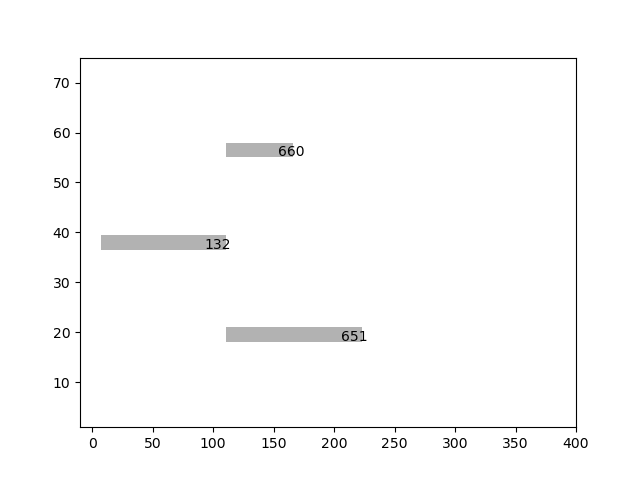

In [30]:
%matplotlib notebook

fig,ax = plt.subplots(1)

for key in list(test['node_areas'].keys())[1:]:
    
    x1 = test['node_areas'][key][0]
    width = int(test['faces'][key*2+1][5])
    
    height=3
    y1 = test['node_areas'][key][1]
    y2 = test['node_areas'][key][3]
    y = (y1+y2)/2 - height/2

    p = plt.Rectangle((x1, y), width=width, height=height,facecolor='black',alpha = 0.3)
    
    text_content = test['faces'][key*2][5]
    
    text_x = test['faces'][key*2][0]
    text_y = test['faces'][key*2+1][3]
    
    plt.text(text_x, text_y, text_content,color='black',verticalalignment='center')
    
    ax.add_patch(p)

y_min = test['node_areas'][0][1]
y_max = test['node_areas'][0][3]

plt.xlim([-10,400])
plt.ylim([y_min,y_max])

plt.show()

In [16]:
%load_ext autoreload
%autoreload 2

import napari_display_functions as my_napari
from ete3 import Tree, TreeStyle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:


family_im = my_napari.generate_family_image(df,labels_layer,current_track,graph_list[0])
plt.imshow(family_im)

NameError: name 'plt' is not defined

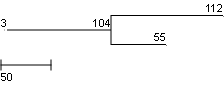

In [93]:
t.render("%%inline",tree_style=ts) 

In [81]:
track_id = 651
np.max(df.loc[df.track_id==track_id,'t'])-np.min(df.loc[df.track_id==track_id,'t'])

112

In [69]:
ts.show_branch_length

True

In [90]:
test['faces'][1]

[75.66666666666667, 15.5, 93.66666666666667, 29.5, 1, '104']

In [108]:
list(test['node_areas'].keys())[1:]

[1, 2, 3]

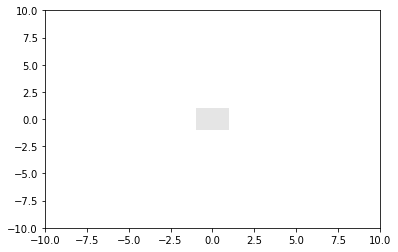

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.path import Path

# Fixing random state for reproducibility
np.random.seed(19680801)


left, bottom, width, height = (-1, -1, 2, 2)
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.1)

fig, ax = plt.subplots()
ax.add_patch(rect)

plt.xlim([-10,10])
plt.ylim([-10,10])

plt.show()

In [ ]:
p = plt.Rectangle((left, bottom), width, height, fill=False)


In [33]:
test = t.render('test.pdf') 
test

{'nodes': [],
 'faces': [[135.3778801843318, 2.0, 156.3778801843318, 18.0, 4, '660']],
 'node_areas': {0: [1.0, 1.0, 183.4884792626728, 18.0],
  1: [3.488479262672811, 1.0, 183.4884792626728, 18.0],
  2: [89.75576036866359, 1.0, 183.4884792626728, 2.0],
  3: [182.65898617511522, 1.0, 183.48847926267283, 2.0],
  4: [89.75576036866359, 2.0, 156.3778801843318, 18.0]}}

In [18]:
ts = TreeStyle()
ts.show_leaf_name = True

test = t.render('family_tree.png',tree_style=ts,w=150,units='mm',dpi=800)

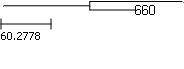

In [21]:
t.render("%%inline")  

In [19]:
test

{'nodes': [],
 'faces': [[3466.777644911525,
   51.216308605085686,
   4004.5488852649246,
   460.9467774457712,
   4,
   '660']],
 'node_areas': {0: [25.60815430254284,
   25.608154302542843,
   4698.801289697457,
   460.9467774457712],
  1: [89.33351523974622,
   25.608154302542843,
   4698.801289697457,
   460.9467774457712],
  2: [2298.4793610627967,
   25.608154302542843,
   4698.801289697457,
   51.216308605085686],
  3: [4677.55950271839,
   25.608154302542843,
   4698.801289697458,
   51.216308605085686],
  4: [2298.4793610627967,
   51.216308605085686,
   4004.5488852649246,
   460.9467774457712]}}

In [154]:
family_im = my_napari.generate_family_image(df,labels_layer,active_label,graph_list[0])

In [156]:
family_im.shape

(240, 4724, 4)

In [124]:
def show_family():
    
    print('test')

In [114]:
show_family()

In [14]:
import napari_display_functions as my_napari
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvas
from matplotlib.figure import Figure

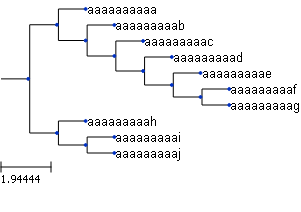

In [26]:
t = Tree()
t.populate(10)
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_length = True
ts.show_branch_support = True
test = t.render('test.pdf') 
t.render("%%inline")  

In [27]:
test

{'nodes': [[26.214285714285715, 76.875, 30.214285714285715, 80.875, 0, None],
  [54.92857142857143, 22.75, 58.92857142857143, 26.75, 1, None],
  [83.64285714285715, 7.0, 87.64285714285715, 11.0, 2, None],
  [83.64285714285714, 38.5, 87.64285714285714, 42.5, 3, None],
  [112.35714285714286, 23.0, 116.35714285714286, 27.0, 4, None],
  [112.35714285714286, 54.0, 116.35714285714286, 58.0, 5, None],
  [141.07142857142858, 39.0, 145.07142857142858, 43.0, 6, None],
  [141.07142857142858, 69.0, 145.07142857142858, 73.0, 7, None],
  [169.7857142857143, 55.0, 173.7857142857143, 59.0, 8, None],
  [169.7857142857143, 83.0, 173.7857142857143, 87.0, 9, None],
  [198.50000000000003, 71.0, 202.50000000000003, 75.0, 10, None],
  [198.50000000000003, 95.0, 202.50000000000003, 99.0, 11, None],
  [227.21428571428575, 87.0, 231.21428571428575, 91.0, 12, None],
  [227.21428571428575, 103.0, 231.21428571428575, 107.0, 13, None],
  [54.92857142857143, 131.0, 58.92857142857143, 135.0, 14, None],
  [83.64285714

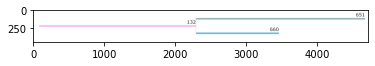

In [18]:
plt.imshow(family_im)

In [78]:
# add family graph display button

family_button = magicgui(show_family, call_button='Show Family')
viewer.window.add_dock_widget(family_button,area='right')

In [34]:
graph

{299: 278, 300: 278, 651: 132, 660: 132, 677: 669, 678: 669}

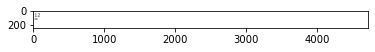

In [26]:
active_label = viewer.layers['Labels'].selected_label
test = my_napari.generate_family_image(df,labels_layer,active_label,graph_list[0])
plt.imshow(test)

In [54]:
viewer.layers['Labels'].selected_label = 5

In [131]:
df = bv_f.df

In [132]:
df.loc[df.track_id==7,['t','track_id','root','parent','generation']]

,t,track_id,root,parent,generation
13118,169,7.0,7.0,7.0,0.0
13119,170,7.0,7.0,7.0,0.0


In [80]:
labels_layer.events.selected_label.connect(points_modified)

<function __main__.points_modified(event)>

selected label changed
selected label changed
selected label changed
